### Research: how well the photodiode signal correlates with Ed values (interpolated to the Lu response time).

#### Terminology:

**Ed (Downwelling Irradiance)** represents the incoming radiant flux (radiant power) from all directions of the upper hemisphere onto a surface (e.g., the Earth's surface or an object). It includes all the incoming electromagnetic radiation, regardless of the direction. It characterizes the total radiant energy received by a surface.

**Lu (Upwelling Radiance)** characterizes the radiant energy that is reflected or emitted by the surface and travels upward.

**Ld (Downwelling Radiance).** Is a measure of the brightness of the radiation coming from the upper hemisphere towards a specific point on the surface. It provides information about the intensity and directionality of the incoming radiation.

Ed represents the incoming energy,
Ld represents the incoming energy's intensity and directionality, and
Lu represents the outgoing energy from the surface or object.

**Photodiodes** are often used to measure the intensity of light in lux. When light falls on a photodiode, it generates an electrical signal, the strength of which is proportional to the illuminance (lux) of the incident light.

**Photodiode Signal and Reflectance Spectrum.** A light source illuminates a material, and the photodiode measures the intensity of the reflected light at various wavelengths. The resulting photodiode signal is used to create a reflectance spectrum, which provides information about how the material reflects light across the visual spectrum. With the photodiode signal in lux and the photopic data, which typically includes the photopic luminous efficiency function V(λ) as a function of wavelength (λ), we can "weighting" the illuminance measurement to account for the human eye's sensitivity to different wavelengths. This calculation provides a way to convert the measured illuminance into a quantity that represents the perceived brightness of light at that specific wavelength. The result is known as "luminance" or "brightness" at that particular wavelength.

**Hypstar water transfer protocol.** 
Ed - Downwelling Irradiance; Ld - Downwelling Radiance; Lu - Upwelling Radiance
Transfer protocol: [Ed 3x] - [Ld 3x] - [Lu 6x] - [Ld 3x] - [Ed 3x]. Sequential measurements.

### Table of contents


#### 1. Load in files
#### 2. Get monitorpd lx windows for each utc from and to pair
#### 3. See if stdev of monitorpd lx windows affects ed0 and ed1 correlation & plot results
<br>
<hr>

#### 1: Load files in

In [1]:
%ls ..\data\LVES

 Volume in drive C is Win 10
 Volume Serial Number is A0A9-CA05

 Directory of C:\Users\Fedor Stomakhin\DataspellProjects\rs-pr-water\src\photodiode\fsevts\data\LVES

10/23/2023  08:18 PM    <DIR>          .
10/23/2023  08:18 PM    <DIR>          ..
10/23/2023  08:19 PM    <DIR>          2023
               0 File(s)              0 bytes
               3 Dir(s)  22,314,483,712 bytes free


In [2]:
%find ..\data\LVES -type f -name "HYPERNETS_W_LVES_L1C_ALL_*.nc"

UsageError: Line magic function `%find` not found.


In [ ]:
# _nc_files_HYPERNETS_W_LVES_L1B_IRR % find ../LVES -type f -name "HYPERNETS_W_LVES_L1B_IRR_*.nc" -exec cp {} . \;
# find ../DATA -type f -name "monitorPD.csv" -exec sh -c 'new_name="./$(basename "$(dirname "$0")").csv"; cp "$0" "$new_name"' {} \;

In [3]:
import sys
sys.path.append('..\\models')
from helpers import _ltt000027_fsevts_02_photodiode_correlation as _ltt000027

In [4]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
from tqdm import tqdm


PATH_TO_DATA = "../data/photodiode/"
PATH_TO_EXPORT = "../data/photodiode/_export/"
PATH_TO_PHOTOPIC = f"{PATH_TO_DATA}photopic.dat"
PATH_TO_HYPERNETS_NC = f"{PATH_TO_DATA}_nc_HYPERNETS_W_LVES_L1B_IRR/"
PATH_TO_MONITORPD_CSV = f"{PATH_TO_DATA}_csv_MONITORPD/"

helper = _ltt000027.Helper()

In [5]:
def get_all_absolute_paths(directory):
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            yield os.path.abspath(os.path.join(dirpath, f))


In [9]:

filepaths_csv = [p for p in get_all_absolute_paths("../data/DATA")]
for filepath in tqdm(filepaths_csv):
    folder_name = filepath.split("\\")[-2]
    shutil.copy2(filepath, f"{PATH_TO_MONITORPD_CSV}{folder_name}.csv")


100%|██████████| 2597/2597 [00:05<00:00, 511.48it/s]


In [10]:
filepaths_nc = [p for p in get_all_absolute_paths("../data/LVES") if "L1C" in p]

In [11]:
df_photopic = helper.read_photopic(PATH_TO_PHOTOPIC)
df_photopic_transformed = helper.transform_photopic(df_photopic)
df_photopic_transformed.to_parquet(f"{PATH_TO_EXPORT}_df_photopic_transformed.parquet", index=False)

In [12]:
dfs_monitorpd = [helper.read_monitorpd(path) for path in helper.get_list_of_files(PATH_TO_MONITORPD_CSV)]
dfs_monitorpd_transformed = [helper.transform_monitorpd(df_) for df_ in dfs_monitorpd]
df_monitorpd_transformed = pd.concat(dfs_monitorpd_transformed, ignore_index=True)
df_monitorpd_transformed = df_monitorpd_transformed.sort_values(by='utc_', ascending=True)
df_monitorpd_transformed.to_parquet(f"{PATH_TO_EXPORT}_df_monitorpd_transformed.parquet", index=False)

In [32]:
# Ed beginning phase
dfs_transformed_nc = [helper.get_nc_transformed_0(path) for path in filepaths_nc]
df_nc_transform = pd.concat(dfs_transformed_nc, ignore_index=True)
df_nc_transform = df_nc_transform.sort_values(by='utc_', ascending=True)
df_nc_transform.to_parquet(f"{PATH_TO_EXPORT}_df_L1C_nc_transformed.parquet", index=False)

In [7]:
df_photopic_transformed = pd.read_parquet(f"{PATH_TO_EXPORT}_df_photopic_transformed.parquet")
df_photopic_transformed

,index,380,385,390,395,400,405,410,415,420,...,735,740,745,750,755,760,765,770,775,780
0,v_lambda_,0.0002,0.000396,0.0008,0.00155,0.0028,0.00466,0.0074,0.0118,0.0175,...,0.000361,0.000249,0.000172,0.00012,0.000085,0.00006,0.000042,0.00003,0.000021,0.000015


In [8]:
wavelen_cols = df_photopic_transformed.select_dtypes(float).columns.tolist()

In [9]:
df_monitorpd_transformed = pd.read_parquet(f"{PATH_TO_EXPORT}_df_monitorpd_transformed.parquet").set_index("utc_")
df_monitorpd_transformed.head(3)

,lx_,lx_inv_
utc_,,
1689915635,20159.0,0.00005
1689915636,20140.8,0.00005
1689915638,20141.6,0.00005


In [10]:
df_l1c = pd.read_parquet(f"{PATH_TO_EXPORT}_df_L1C_nc_transformed.parquet")
df_nc_transform_0 = pd.read_parquet(f"{PATH_TO_EXPORT}_df_nc_transformed_0.parquet")
df_nc_transform_1 = pd.read_parquet(f"{PATH_TO_EXPORT}_df_nc_transformed_1.parquet")

In [11]:
print(df_l1c.shape, df_nc_transform_0.shape, df_nc_transform_1.shape)

(1044, 752) (1773, 752) (1773, 752)


In [12]:
df_l1c.head(2)

,utc_,350,351,352,353,354,355,356,357,358,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,1689915717,140.921863,145.900451,149.959138,153.382711,164.249083,164.780394,154.911738,143.874639,138.086133,...,152.643626,154.147272,141.336268,140.855295,140.014967,135.004937,136.831519,134.327537,125.613644,148.478704
1,1689916616,162.314765,168.175529,171.187373,175.443774,186.857203,189.598041,177.417595,164.372807,157.331809,...,178.945896,175.028144,176.300773,161.895281,168.315816,167.271874,159.073206,157.489936,143.709163,160.618076


In [13]:
df_nc_transform_0.head(2)

,utc_,350,351,352,353,354,355,356,357,358,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,1689915676,139.896606,145.060913,149.192886,152.974747,164.423500,163.010925,156.661385,145.117345,138.356697,...,149.501770,154.458481,146.774132,140.697375,128.467457,123.450153,130.477936,124.133533,121.280273,148.973389
1,1689916575,161.907890,168.990608,170.145760,176.260399,187.366058,188.746529,180.372185,166.402359,157.716202,...,169.179604,174.959175,174.539085,156.256490,178.930298,164.121323,153.947281,146.457596,143.814651,141.991196


In [14]:
df_nc_transform_1.head(2)

,utc_,350,351,352,353,354,355,356,357,358,...,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100
0,1689915754,142.550522,147.574211,150.712372,154.669807,164.871346,166.075813,158.392525,144.982076,137.421059,...,151.593727,156.967537,140.197639,141.519674,145.308426,145.080521,143.925034,143.351284,125.748226,136.977936
1,1689916652,163.663124,168.368553,171.821381,175.707245,187.733711,190.072006,180.430077,165.348012,156.123352,...,188.054024,173.735954,182.840248,163.104975,164.546234,173.787094,162.730103,169.695465,144.259354,165.980408


In [15]:
df_nc_transform_0["utc_to"] = df_nc_transform_1["utc_"]
df_nc_transform_0["utc_from"] = df_nc_transform_0["utc_"]

In [16]:
mid_result = df_nc_transform_0[["utc_from", "utc_to"]].apply(lambda row: (df_l1c["utc_"] > row["utc_from"]) & (df_l1c["utc_"] < row["utc_to"]), axis=1).head(15)

In [18]:
import numpy as np
# get std of monitorpd lx values from transform_0 utc to transform_1 utc
df_nc_transform_0["utc_to"] = df_nc_transform_1["utc_"]
df_nc_transform_0["utc_from"] = df_nc_transform_0["utc_"]

# align df_l1c so that each value is between utc_to and utc_from
df_nc_transform_0["utc_mid"] = df_nc_transform_0[["utc_from", "utc_to"]] \
    .apply(lambda row: (df_l1c["utc_"] > row["utc_from"]) & (df_l1c["utc_"] < row["utc_to"]), axis=1) \
    .apply(lambda x: np.where(x.values)[0], axis=1) \
    .apply(lambda x: int(x[0]) if len(x) != 0 else np.nan) \
    .apply(lambda x: df_l1c["utc_"].loc[x] if not np.isnan(x) else np.nan)

#### 2: Get lx windows for each from;to pair

In [19]:
df_utc = df_nc_transform_0[["utc_from", "utc_to", "utc_mid"]]

In [20]:
import numpy as np
def get_lx_l1c(row):
    try:
        return df_monitorpd_transformed.loc[int(row["utc_mid"])].lx_
    except:
        return np.nan

def get_lx_seq(row):
    utc_from, utc_to = row["utc_from"], row["utc_to"]
    subdf = df_monitorpd_transformed.loc[utc_from:utc_to].lx_
    return subdf.to_numpy()

In [21]:
df_utc["monitorpd_l1c"] = df_utc.apply(get_lx_l1c, axis=1)
df_utc["monitorpd_seq"] = df_utc.apply(get_lx_seq, axis=1)

##### 2.1: Generate lx metric

In [22]:
df_l1c["lx_l1c"] = df_l1c[wavelen_cols] @ df_photopic_transformed[wavelen_cols].T
df_nc_transform_0["lx_ed0"] = df_nc_transform_0[wavelen_cols] @ df_photopic_transformed[wavelen_cols].T # dot product
df_nc_transform_1["lx_ed1"] = df_nc_transform_1[wavelen_cols] @ df_photopic_transformed[wavelen_cols].T

In [23]:
df_utc["monitorpd_seq_std"] = df_utc["monitorpd_seq"].apply(lambda x: x.std())
df_utc["monitorpd_seq_maxmin"] = df_utc["monitorpd_seq"].apply(lambda x: x.max()-x.min())
df_utc["monitorpd_seq_change"] = df_utc["monitorpd_seq"].apply(lambda x: x[-1]-x[0])

In [24]:
df_utc = df_utc \
    .merge(df_l1c[["utc_", "lx_l1c"]], left_on="utc_mid", right_on="utc_", how="left").drop(columns=["utc_"]) \
    .merge(df_nc_transform_0[["utc_", "lx_ed0"]], left_on="utc_from", right_on="utc_", how="left").drop(columns=["utc_"]) \
    .merge(df_nc_transform_1[["utc_", "lx_ed1"]], left_on="utc_to", right_on="utc_", how="left").drop(columns=["utc_"])

##### 2.2: Calculate ed fraction

In [25]:
df_utc.head(10)

,utc_from,utc_to,utc_mid,monitorpd_l1c,monitorpd_seq,monitorpd_seq_std,monitorpd_seq_maxmin,monitorpd_seq_change,lx_l1c,lx_ed0,lx_ed1
0,1689915676,1689915754,1.689916e+09,20502.7,"[20098.5, 20107.6, 20130.8, 20136.6, 20171.5, ...",167.005753,600.0,600.0,10311.155500,10288.083922,10340.337894
1,1689916575,1689916652,1.689917e+09,25446.1,"[25260.2, 25232.0, 25260.2, 25256.9, 25286.8, ...",55.314376,233.2,41.5,12152.582952,12160.575194,12164.250095
2,1689917475,1689917550,1.689918e+09,27542.7,"[26873.7, 26882.9, 26918.6, 26925.2, 26950.9, ...",449.451533,1567.9,1567.9,12669.669446,12661.611588,12693.590911
3,1689918376,1689918452,1.689918e+09,35592.1,"[35610.3, 35629.4, 35622.8, 35640.2, 35645.2, ...",189.374924,766.1,-488.0,14455.234912,14576.137043,14358.155693
4,1689919276,1689919350,1.689919e+09,37194.8,"[37216.4, 37189.8, 37184.8, 37184.8, 37155.0, ...",62.295371,268.1,-195.1,15562.389364,15737.864637,15435.035716
5,1689920180,1689920255,NaN,NaN,"[11003.3, 10690.4, 10346.0, 10170.8, 10062.1, ...",8911.918589,28909.7,27855.6,NaN,4872.898451,16233.904476
6,1689921179,1689921249,1.689921e+09,50362.6,"[51267.2, 51222.8, 51213.6, 51219.1, 51195.1, ...",665.317927,2016.5,-1942.5,19544.453676,19554.494222,19545.092666
7,1689921975,1689922048,NaN,NaN,"[43018.1, 43024.7, 43018.9, 43018.1, 43028.0, ...",444.296702,1591.1,1586.9,NaN,18693.903157,18978.812905
8,1689922875,1689922949,NaN,NaN,"[26399.8, 25751.6, 26090.2, 27878.0, 29892.5, ...",13526.519793,36768.3,30273.1,NaN,10369.515454,21586.181730
9,1689923775,1689923850,1.689924e+09,55466.7,"[54830.3, 54843.3, 54822.9, 54822.9, 54804.4, ...",833.666768,2347.6,2292.2,21449.357772,21334.252648,21579.706515


In [26]:
df_utc["frac_ed_l1c"] = df_utc["lx_l1c"] / df_utc["monitorpd_l1c"]
df_utc["monitorpd_from"] = df_utc["monitorpd_seq"].str[0]
df_utc["monitorpd_to"] = df_utc["monitorpd_seq"].str[-1]
df_utc["frac_ed0"] = df_utc["lx_ed0"] / df_utc["monitorpd_from"]
df_utc["frac_ed1"] = df_utc["lx_ed1"] / df_utc["monitorpd_to"]
df_utc["frac_ed_mean"] = (df_utc["frac_ed0"] + df_utc["frac_ed1"])/2
df_utc["utc_delta"] = df_utc["utc_to"] - df_utc["utc_from"]
df_utc["l1c_excluded"] = df_utc["frac_ed_l1c"].isna()
df_utc["frac_ratio"] = df_utc["frac_ed0"] / df_utc["frac_ed1"]

In [27]:
df_utc = df_utc[["utc_from", "utc_to", "utc_mid", "monitorpd_seq", "lx_l1c", "lx_ed0", "lx_ed1", "frac_ed_l1c", "frac_ed_mean", "frac_ed0", "frac_ed1", "monitorpd_seq_std", "monitorpd_seq_maxmin", "monitorpd_seq_change", "l1c_excluded", "frac_ratio"]]

#### 3: See if ed0 and ed1 relationship affected by lx error metrics

<Axes: >

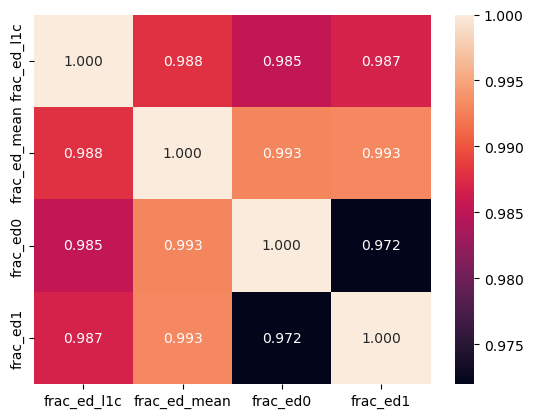

In [28]:
import seaborn as sns
sns.heatmap(df_utc[["frac_ed_l1c", "frac_ed_mean", "frac_ed0", "frac_ed1"]].corr(), annot=True, fmt=".3f")

In [29]:
(df_utc["frac_ed_l1c"] - df_utc["frac_ed_mean"]).abs().corr(df_utc["monitorpd_seq_maxmin"])

0.5572791120078541

In [30]:
(df_utc["frac_ed_l1c"] - df_utc["frac_ed_mean"]).abs().corr(df_utc["monitorpd_seq_change"])

-0.058243366738789965

In [31]:
(df_utc["frac_ed_l1c"] - df_utc["frac_ed_mean"]).abs().corr(df_utc["monitorpd_seq_std"])

0.5908279590038692

In [32]:
df_utc["monitorpd_seq_std"].corr(df_utc["l1c_excluded"])

0.28758942047162867

In [33]:
df_utc.groupby("l1c_excluded")[["monitorpd_seq_std", "monitorpd_seq_maxmin"]].mean()

,monitorpd_seq_std,monitorpd_seq_maxmin
l1c_excluded,,
False,598.137520,2130.751949
True,2393.873802,7743.499465


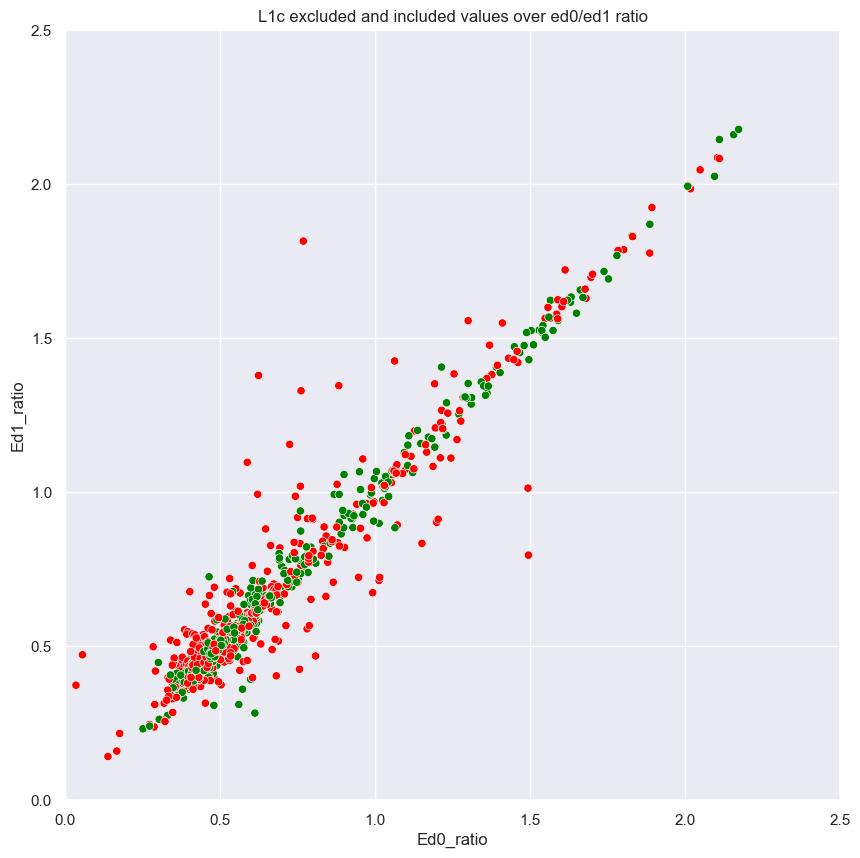

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

quantiles = [0, .01, .025, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .975, .99, 1]
sns.set_theme(style="darkgrid", palette="bright")
# df_mask = df_utc["monitorpd_seq_std"] < df_utc["monitorpd_seq_std"].quantile(.5)
# correlation = df_utc[df_mask]["frac_ed0"].corr(df_utc[df_mask]["frac_ed1"], method='pearson')
plt.rcParams["figure.figsize"] = (10, 10)
sns.scatterplot(data=df_utc, x="frac_ed0", y="frac_ed1", c=df_utc["l1c_excluded"].map({True: "red", False: "green"}))
plt.title(f"L1c excluded and included values over ed0/ed1 ratio")
plt.xlim(0, 2.5)
plt.ylim(0, 2.5)
plt.xlabel('Ed0_ratio')
plt.ylabel('Ed1_ratio')

plt.show()

In [35]:
df_utc["l1c_excluded_int"] = df_utc["l1c_excluded"].astype(int)

<Axes: xlabel='l1c_excluded_int', ylabel='frac_ratio'>

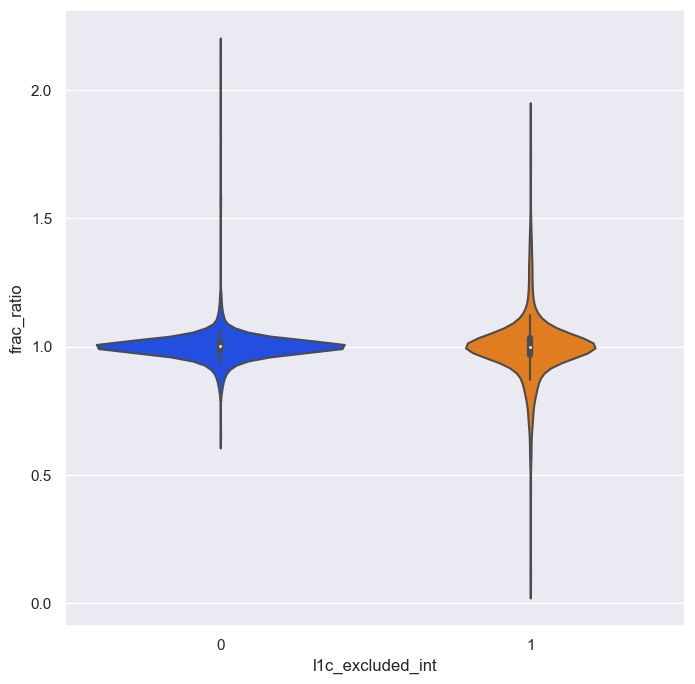

In [36]:
plt.rcParams["figure.figsize"] = (8, 8)
sns.violinplot(data=df_utc, x="l1c_excluded_int", y="frac_ratio")

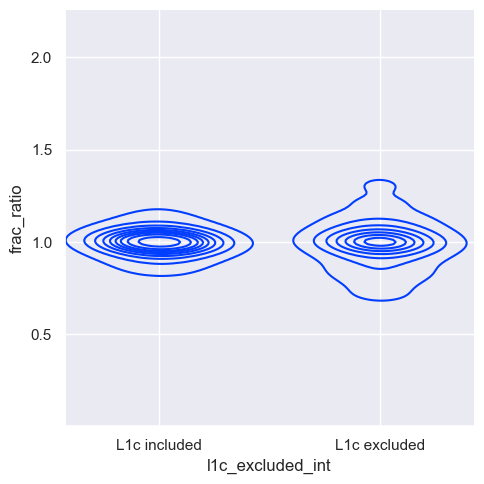

In [37]:
plt.rcParams["figure.figsize"] = (8, 8)
sns.displot(data=df_utc, x="l1c_excluded_int", y="frac_ratio", kind="kde")
plt.xticks([0, 1], ["L1c included", "L1c excluded"])
plt.show()

It seems that the ed0/ed1 ratio is indeed important for including and excluding values in the L1C process, as the std of the frac_ratio in the excluded distribution is much higher, meaning that there are more extreme ed0/ed1 values in the set of excluded timesteps.

In [40]:
df_utc["monitorpd_seq_change_abs"] = df_utc["monitorpd_seq_change"].abs()

In [41]:
worst_5 = df_utc[df_utc["l1c_excluded"]] \
    .head()[["utc_from", "utc_to", "utc_mid", "monitorpd_seq"]]
#.sort_values("monitorpd_seq_std", ascending=False) \
best_5 = df_utc[~df_utc["l1c_excluded"]] \
    .head()[["utc_from", "utc_to", "utc_mid", "monitorpd_seq"]]
#.sort_values("monitorpd_seq_std", ascending=True) \

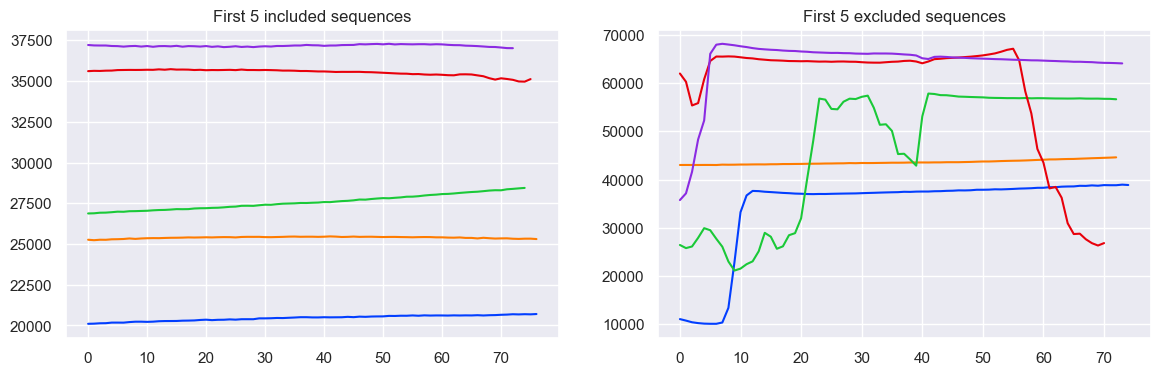

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

for rownr, row in best_5.iterrows():
    ax1.plot(row["monitorpd_seq"])
ax1.set_title("First 5 included sequences")
for rownr, row in worst_5.iterrows():
    ax2.plot(row["monitorpd_seq"])
ax2.set_title("First 5 excluded sequences")
fig.show()

In [62]:
df_utc[pd.to_datetime(df_utc["utc_from"]*10e9).dt.month < 8]

,utc_from,utc_to,utc_mid,monitorpd_seq,lx_l1c,lx_ed0,lx_ed1,frac_ed_l1c,frac_ed_mean,frac_ed0,frac_ed1,monitorpd_seq_std,monitorpd_seq_maxmin,monitorpd_seq_change,l1c_excluded,frac_ratio,l1c_excluded_int,monitorpd_seq_change_abs


0        True
1        True
2        True
3        True
4        True
        ...  
1768    False
1769    False
1770    False
1771    False
1772    False
Name: utc_from, Length: 1773, dtype: bool

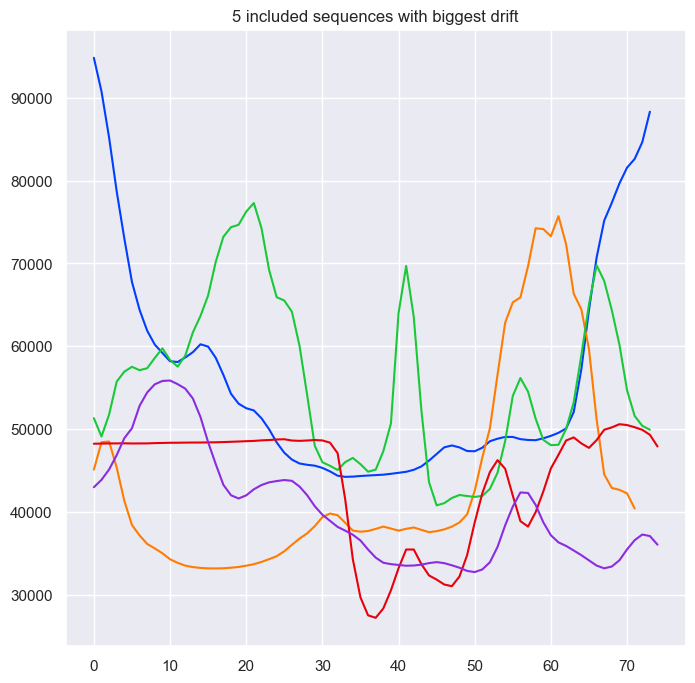

In [82]:
worst_5_included = df_utc \
    [pd.to_datetime(df_utc["utc_from"]*10e8).dt.month < 8] \
    [~df_utc["l1c_excluded"]] \
    .sort_values("monitorpd_seq_std", ascending=False) \
    .head()[["utc_from", "utc_to", "utc_mid", "monitorpd_seq"]]

for rownr, row in worst_5_included.iterrows():
    plt.plot(row["monitorpd_seq"])
plt.title("5 included sequences with biggest drift")
plt.show()

In [71]:
start_folder = "C:\\Users\\Fedor Stomakhin\\Downloads\\waterhypernet\\hypstar\\processed20230317\\LVES\\2023"

In [72]:
start_folder

'C:\\Users\\Fedor Stomakhin\\Downloads\\waterhypernet\\hypstar\\processed20230317\\LVES\\2023'

In [73]:
def filename_to_datetime(fname):
    return pd.to_datetime(fname.split("IMG_")[1].split("_")[0])
print(filename_to_datetime("HYPERNETS_W_LVES_IMG_20230506T0502_20230509T0031_006_140_-135_v1.0.jpg"))

2023-05-06 05:02:00


In [74]:
worst_5["utc_from_dt"] = pd.to_datetime(worst_5["utc_from"]*1e9).dt.floor('h')
#worst_5["utc_mid_dt"] = pd.to_datetime(worst_5["utc_mid"]*1e9).dt.floor('h')
worst_5["utc_to_dt"] = pd.to_datetime(worst_5["utc_to"]*1e9).dt.ceil('h')
best_5["utc_from_dt"] = pd.to_datetime(best_5["utc_from"]*1e9).dt.floor('h')
#worst_5["utc_mid_dt"] = pd.to_datetime(worst_5["utc_mid"]*1e9).dt.floor('h')
best_5["utc_to_dt"] = pd.to_datetime(best_5["utc_to"]*1e9).dt.ceil('h')

worst_5_included["utc_from_dt"] = pd.to_datetime(worst_5_included["utc_from"]*1e9).dt.ceil('h')
worst_5_included["utc_to_dt"] = pd.to_datetime(worst_5_included["utc_to"]*1e9).dt.ceil('h')

In [76]:
def included_filename(row: dict, fname: str):
    dt = filename_to_datetime(fname)
    return (dt >= row["utc_from_dt"]) and (dt <= row["utc_to_dt"])

In [49]:
image_paths = [path for path in get_all_absolute_paths(start_folder) if (".jpg" in path) and ("140_-135" in path)]

In [50]:
from PIL import Image

In [510]:
row_idx_to_file = {}
for row_idx, row in worst_5.iterrows():
    filtered = list(filter(lambda x: included_filename(row, x), image_paths))
    top_5_files = filtered[:5]
    row_idx_to_file[row_idx] = top_5_files
    #print(len(filtered), filtered)

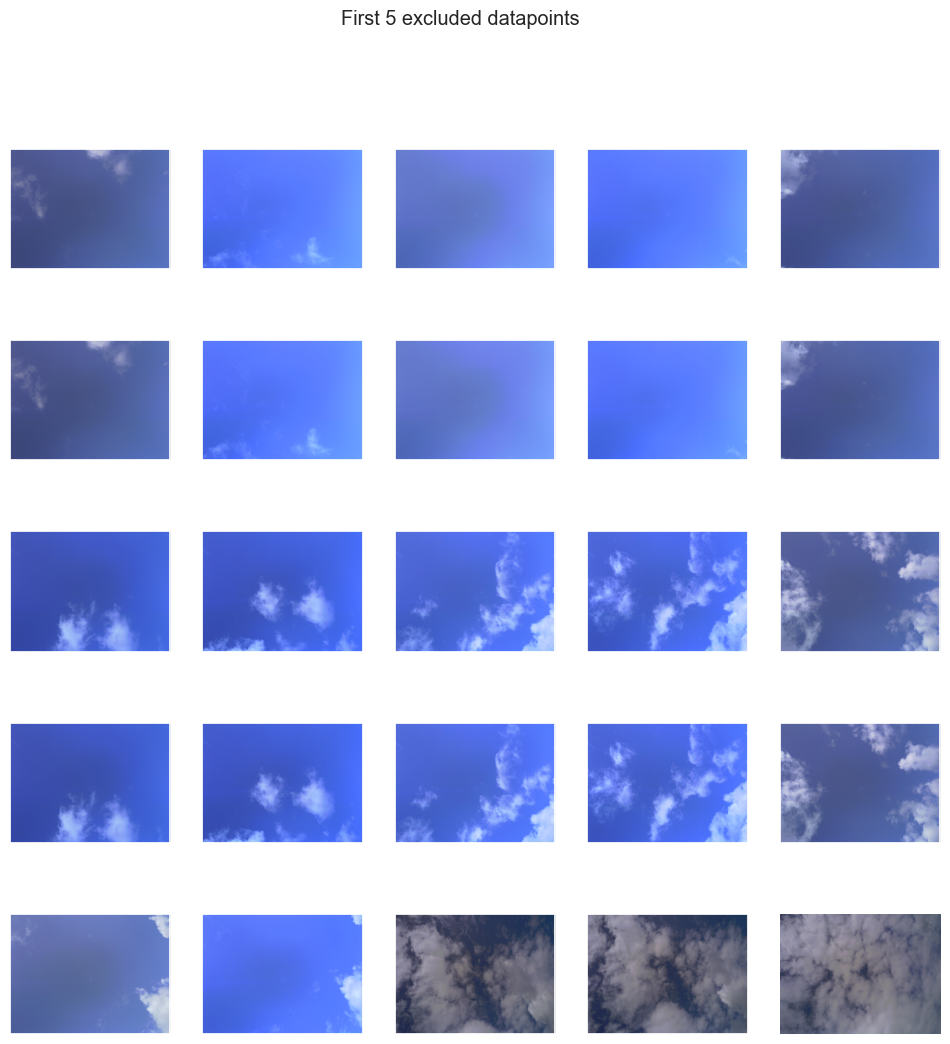

In [511]:
f, axarr = plt.subplots(5,5, figsize=(12, 12))
plt.axis("off")
plt.rcParams['axes.grid'] = False

ax_idx = 0
for row_idx, row in worst_5.iterrows():
    for col_idx, img_path in enumerate(row_idx_to_file[row_idx]):
        img = Image.open(img_path)
        axarr[ax_idx, col_idx].imshow(img)
        axarr[ax_idx, col_idx].tick_params(which = "both", left = False, right = False , labelleft = False ,
                                          labelbottom = False, bottom = False, )
        axarr[ax_idx, col_idx].grid(False)
    ax_idx += 1
plt.suptitle("First 5 excluded datapoints")
plt.show()
plt.rcParams['axes.grid'] = True

In [507]:
row_idx_to_file = {}
for row_idx, row in best_5.iterrows():
    filtered = list(filter(lambda x: included_filename(row, x), image_paths))
    top_5_files = filtered[:5]
    row_idx_to_file[row_idx] = top_5_files
    #print(len(filtered), filtered)

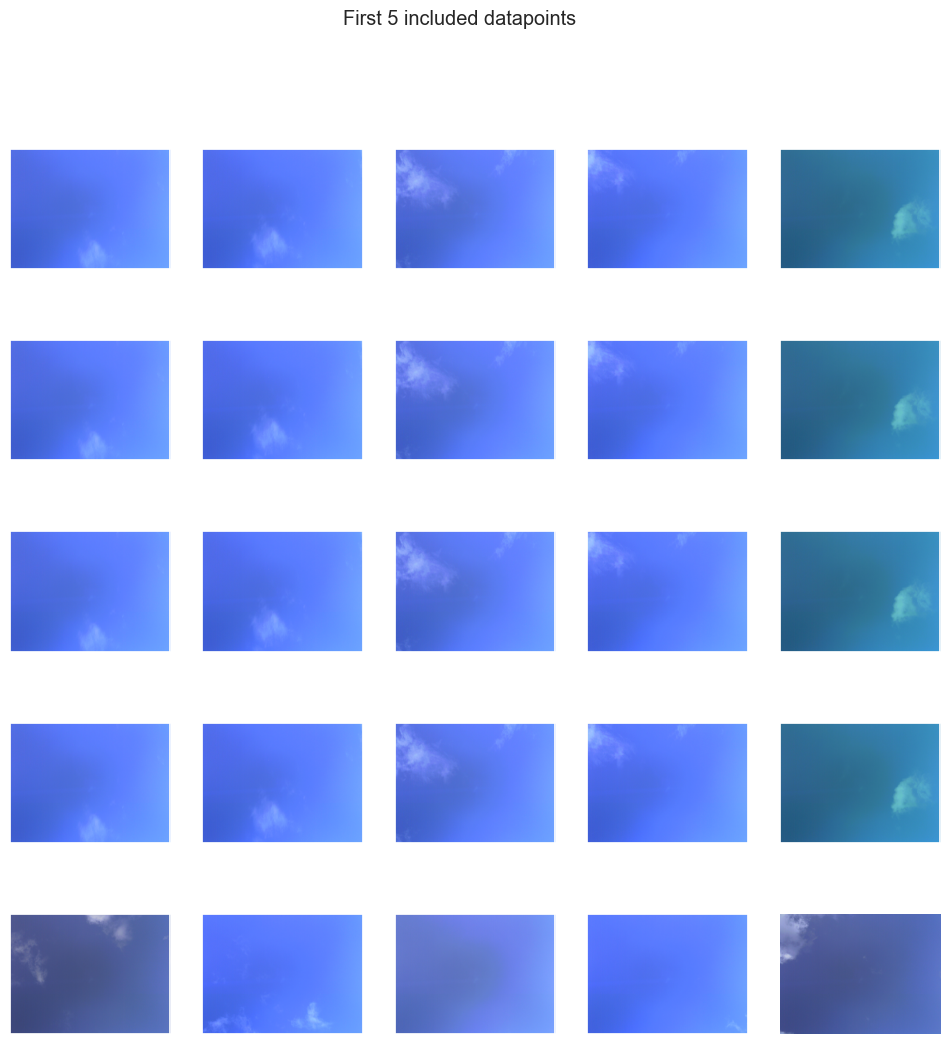

In [509]:
f, axarr = plt.subplots(5,5, figsize=(12, 12))
plt.axis("off")
plt.rcParams['axes.grid'] = False

ax_idx = 0
for row_idx, row in best_5.iterrows():
    for col_idx, img_path in enumerate(row_idx_to_file[row_idx]):
        img = Image.open(img_path)
        axarr[ax_idx, col_idx].imshow(img)
        axarr[ax_idx, col_idx].tick_params(which = "both", left = False, right = False , labelleft = False ,
                                           labelbottom = False, bottom = False, )
        axarr[ax_idx, col_idx].grid(False)
    ax_idx += 1
plt.suptitle("First 5 included datapoints")
plt.show()
plt.rcParams['axes.grid'] = True

In [59]:
worst_5_included

,utc_from,utc_to,utc_mid,monitorpd_seq,utc_to_dt,utc_from_dt
1498,1695728784,1695728861,1.695729e+09,"[24323.2, 24861.8, 25063.5, 25033.6, 25349.9, ...",2023-09-26 12:00:00,2023-09-26 12:00:00
1402,1695548785,1695548861,1.695549e+09,"[34938.0, 35532.3, 35501.6, 37766.7, 40564.6, ...",2023-09-24 10:00:00,2023-09-24 10:00:00
571,1693731683,1693731760,1.693732e+09,"[50667.4, 46875.3, 46327.7, 52911.9, 66870.1, ...",2023-09-03 10:00:00,2023-09-03 10:00:00
1703,1696247182,1696247280,1.696247e+09,"[23256.6, 23385.3, 23504.8, 23518.1, 23677.4, ...",2023-10-02 12:00:00,2023-10-02 12:00:00
1550,1695897983,1695898060,1.695898e+09,"[42863.7, 41620.4, 41094.1, 42269.4, 43420.6, ...",2023-09-28 11:00:00,2023-09-28 11:00:00


In [77]:
row_idx_to_file = {}
for row_idx, row in worst_5_included.iterrows():
    filtered = list(filter(lambda x: included_filename(row, x), image_paths))
    top_5_files = filtered[:5]
    row_idx_to_file[row_idx] = top_5_files
    #print(len(filtered), filtered)

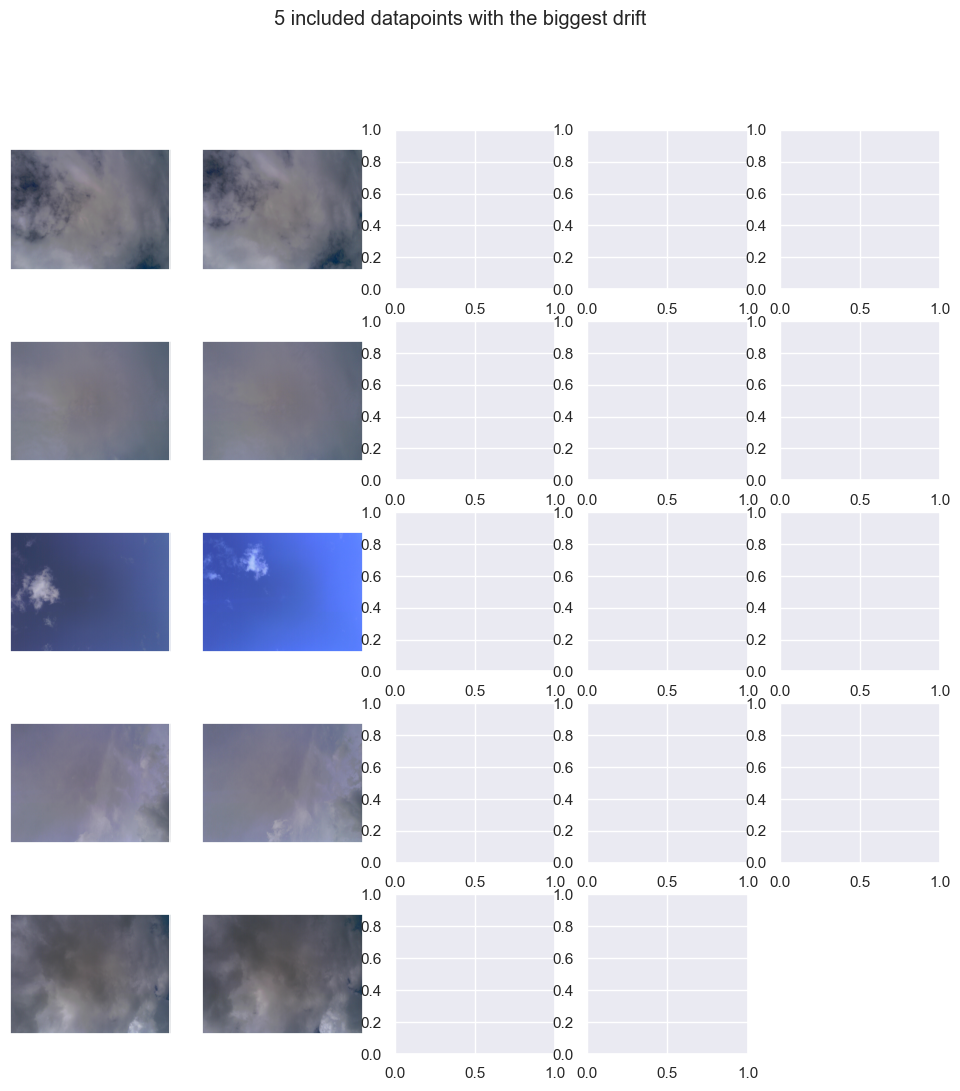

In [78]:
f, axarr = plt.subplots(5,5, figsize=(12, 12))
plt.axis("off")
plt.rcParams['axes.grid'] = False

ax_idx = 0
for row_idx, row in worst_5_included.iterrows():
    for col_idx, img_path in enumerate(row_idx_to_file[row_idx]):
        img = Image.open(img_path)
        axarr[ax_idx, col_idx].imshow(img)
        axarr[ax_idx, col_idx].tick_params(which = "both", left = False, right = False , labelleft = False ,
                                           labelbottom = False, bottom = False, )
        axarr[ax_idx, col_idx].grid(False)
    ax_idx += 1
plt.suptitle("5 included datapoints with the biggest drift")
plt.show()
plt.rcParams['axes.grid'] = True